In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import base
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor


## Map utils

In [4]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 


global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111



## Entreno el modelo que vamos a usar para predecir

In [5]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [6]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [7]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

In [ ]:
random_predictor = RandomPredictor()
random_predictor.fit(regre_data, regre_target)

## Levanto el archivo con las emisiones de los pajaros

In [8]:
#birds_recep = sc.read.json('datos/day-birds.jsonlines/').rdd
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
#birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

# Error analysis

### Mapa con el movimiento predicho para un pajaro

In [9]:
def update_animation(data, p):
    x = data[0]
    y = data[1]
    p.set_data(x, y)
    plt.title(data[7])
    return p
 

def show_birds_movement(predictions, delay=200):
    fig, ax = plt.subplots()
    point, = ax.plot([0], [0], 'go', color='red')
    point.set_data(0, 0)
    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
    plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
    for antenna in range(4):
            pos_antena = posicion_antenas[antenna]
            plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
    ani = animation.FuncAnimation(fig, update_animation, predictions, interval=delay, fargs=(point,))


In [12]:
BIRD_TAG_ID = 20
START_TIME = '2018-01-09 22:00:00'
END_TIME = '2018-01-10 05:00:00'

single_bird = (
    birds_recep
    .filter(lambda x: x['tag_id'] == BIRD_TAG_ID)
    .filter(lambda x: x['timestamp'] >= START_TIME and x['timestamp'] < END_TIME)
    .sortBy(lambda x: x['timestamp'])
)

birds_data = pd.DataFrame(single_bird.collect()).drop(columns=[4,5])

In [13]:
predictions = predictor.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), pd.DataFrame(single_bird.collect())], axis=1).values

In [14]:
from utils.smoother import Smoother

smoother = Smoother(window_threshold=300)
#smooth_predictions_np = smoother.smooth_predictions(predictions)
smooth_predictions_np = predictions
#smooth_predictions_np = smoother.filter_predictions(predictions)

In [15]:
len(smooth_predictions_np)

2807

<IPython.core.display.Javascript object>


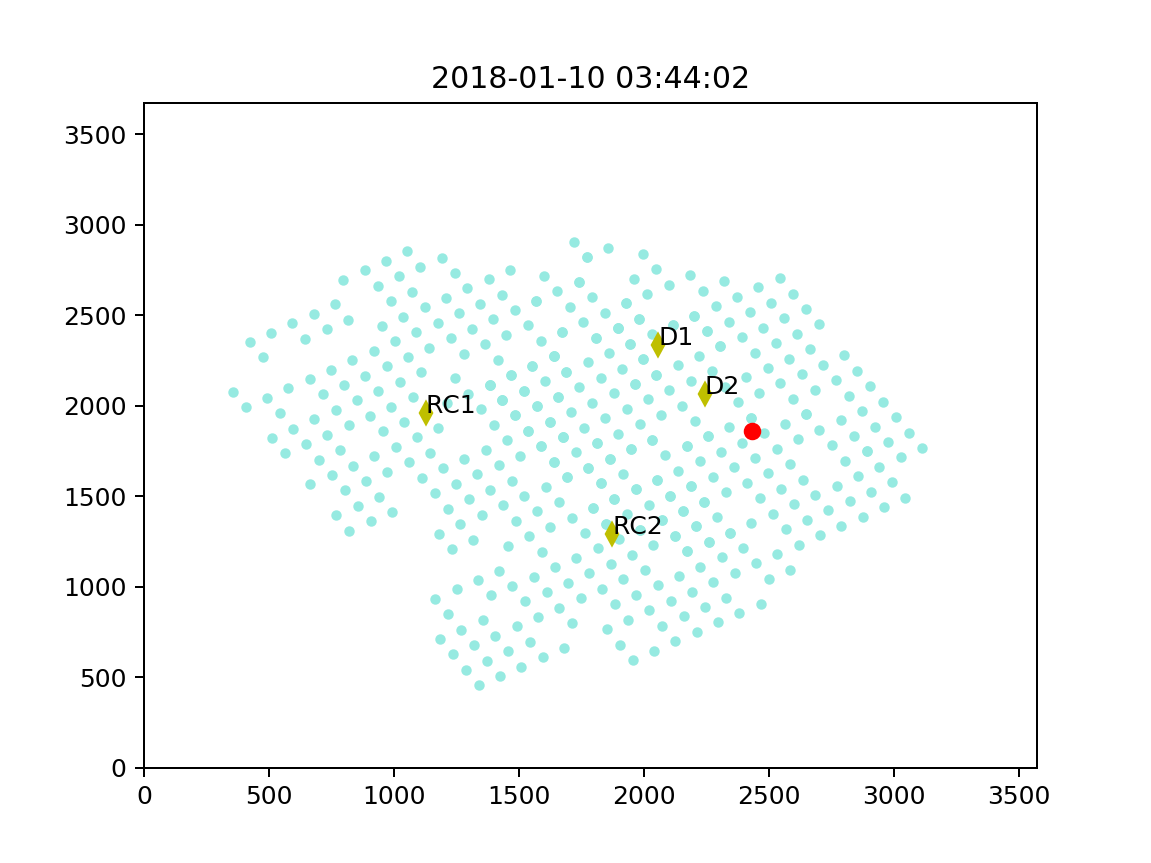

In [17]:
DELAY = 30
#show_birds_movement(predictions)

fig, ax = plt.subplots()
point, = ax.plot([0], [0], 'go', color='red')
point.set_data(0, 0)
plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalizer._normalize_positions).collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        name = nombre_antenas[antenna]
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 
        
ani = animation.FuncAnimation(fig, update_animation, smooth_predictions_np, interval=DELAY, fargs=(point,), repeat=False)



###  Mapa con el movimiento incluyendo stdev de la prediccion

In [41]:
from statsmodels.stats.weightstats import DescrStatsW
from matplotlib.patches import Ellipse

In [42]:
regre_data_pd = pd.DataFrame(regre_data)
regre_target_pd = pd.DataFrame(regre_target)


#### Calculo stdev del eje x

In [43]:
neigh_dist, neigh_ind = predictor.clf.estimators_[0].kneighbors(birds_data)

weights = base._get_weights(neigh_dist, 'distance')

stdev_x = []

for i in range(len(birds_data)):
    weighted_stats = DescrStatsW(regre_target_pd.iloc[neigh_ind[i]][0], weights=weights[i], ddof=0)
    stdev_x.append(weighted_stats.std)
    


#### Calculo stdev del eje y

In [44]:
neigh_dist, neigh_ind = predictor.clf.estimators_[1].kneighbors(birds_data)

weights = base._get_weights(neigh_dist, 'distance')

stdev_y = []

for i in range(len(birds_data)):
    weighted_stats = DescrStatsW(regre_target_pd.iloc[neigh_ind[i]][1], weights=weights[i], ddof=0)
    stdev_y.append(weighted_stats.std)
    


#### Calculo predicciones y le agrego los stdev

In [45]:


predictions = predictor.predict(birds_data)

stdev_x_np = np.array(stdev_x).reshape(len(stdev_x),1)
stdev_y_np = np.array(stdev_y).reshape(len(stdev_y),1)

stdev_xy = np.concatenate((stdev_x_np,stdev_y_np), axis=1)

predictions_with_stdev = np.concatenate((predictions,stdev_xy), axis=1)

predictions_with_stdev = pd.concat([pd.DataFrame(predictions_with_stdev), pd.DataFrame(single_bird.collect())], axis=1).values

#### Grafico el mapa con las predicciones

In [60]:
def update_animation(data, p, circ):
    x = data[0]
    y = data[1]
    p.set_data(x, y)
    plt.title(data[9])
    if len(data) > 2:
        stdev_x = data[2]
        stdev_y = data[2]
        circ.center = (x, y)
        circ.width = stdev_x
        circ.height = stdev_y
        
    return p

<IPython.core.display.Javascript object>


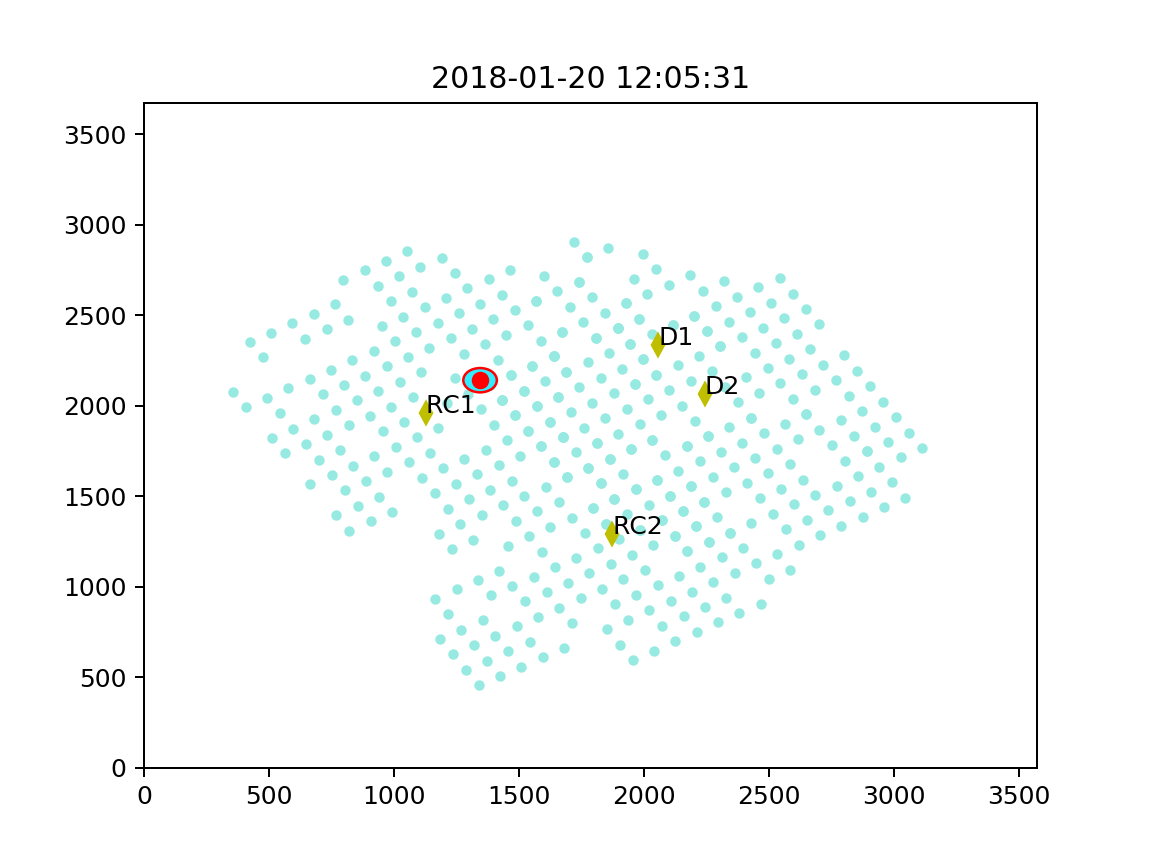

In [61]:
DELAY = 100
fig, ax = plt.subplots()
point, = ax.plot([0], [0], 'go', color='red')
point.set_data(0, 0)

circle = Ellipse((-1000, -1000), 0, 0, fill=True)
circle.set_edgecolor('red')
circle.set_facecolor('#31ecff')
ax.add_artist(circle)
 

plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        name = nombre_antenas[antenna]
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 
ani = animation.FuncAnimation(fig, update_animation, predictions_with_stdev, interval=DELAY, fargs=(point,circle,), repeat=False)



## Notas:

### Metodo usado para calcular weigthed stdev 

In [ ]:
a = regre_target_pd.iloc[neigh_ind[0]][1]
b = weights[0]

s = sum(b)
m = (a*b/s).sum()

res = 0
for i in range(len(a)):
    res += (a.iloc[i]-m)**2*b[i]/s
    
math.sqrt(res)

In [12]:
data.take(1)

[{'data': {'antenna_0': 0, 'antenna_1': 0, 'antenna_2': 0, 'antenna_3': 29},
  'x': 2854.782011563948,
  'y': 2192.894688980654,
  'point': 367}]

<IPython.core.display.Javascript object>


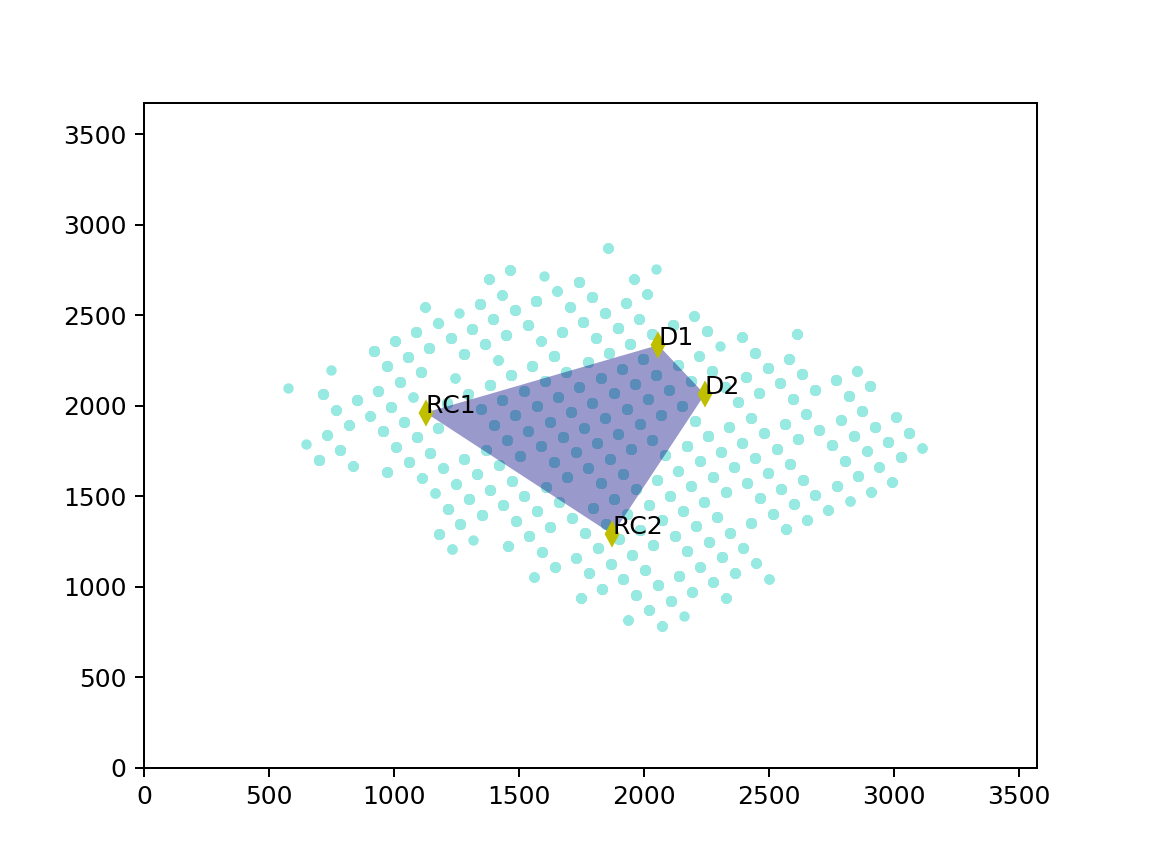

In [18]:
DELAY = 300

fig, ax = plt.subplots()
plt.ylim(0,y_f-y_0)
plt.xlim(0,x_f-x_0)
all_points_pos = pd.DataFrame(data.collect())
plt.scatter(all_points_pos['x'], all_points_pos['y'], c='#96EAE1', s=10)
for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        name = nombre_antenas[antenna]
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 
ax.add_collection(p)
#ani = animation.FuncAnimation(fig, update_animation, smooth_predictions_np, interval=DELAY, fargs=(point,), repeat=False)



In [14]:
from shapely.geometry.polygon import Polygon
ANTENNAS_POSITION = [(464259.981343845,6110331.85100085),(463512.015195402,6111004.324434620),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
ANTENNAS_NAMES = ["RC1", "RC2", "D1", "D2"] 
X_0 = 462385.503783397
Y_0 = 6109042.35153865

for i in range(4):
    ANTENNAS_POSITION[i] = (ANTENNAS_POSITION[i][0]-X_0, ANTENNAS_POSITION[i][1]-Y_0)

GRID = Polygon(ANTENNAS_POSITION)

In [17]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

patches = []
polygon = Polygon(ANTENNAS_POSITION, True)
patches.append(polygon)

p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
colors = 100*np.random.rand(1)
p.set_array(np.array(colors))
